In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load Data

In [2]:
data_dir = Path('/g/data/gb02/cd3022/hot-and-cloudy/solar-pv/GCCSA/ideal-actual')
files = list(data_dir.glob("*.nc"))
datasets = []

for file in files:
    region_name = file.stem[1:5]
    ds_reg = xr.open_dataset(file)
    ds_reg = ds_reg.expand_dims(region=[region_name])

    datasets.append(ds_reg)

ds = xr.concat(datasets, dim='region')

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/xp65/public/./apps/med_conda/envs/analysis3-25.06/share/proj failed


# Preprocessing

Same preprocessing steps as previously

In [3]:
# Change times to AEST
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

rated_capacity = 219.656729124
ds = ds.apply(lambda x: x / rated_capacity)

ds = xr.where(ds.isnull(), 0, ds)

# Plotting Example Day

This dataset has added a variable to the previous dataset. Whereas previously the data was just solar PV output from Himawari irradiance input, there is now also solar PV output from estimated clearsky irradiance input. These are labelled "actual" and "ideal" respectively.

Comparing the actual to ideal generation gives a more representative measure of how cloudy each location is, as it is not affected by the changing angle of the sun due to the season or latitude.

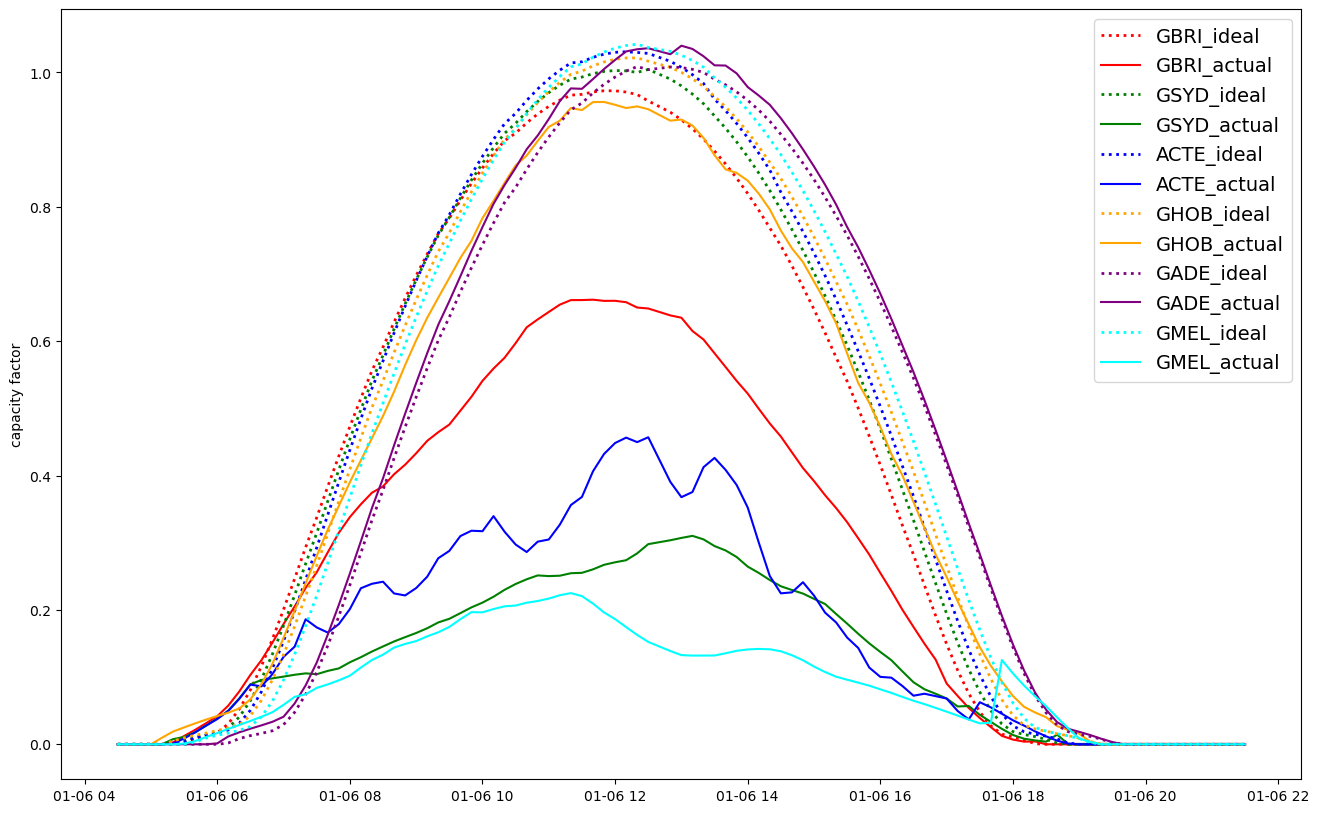

In [14]:
date = '2020-01-06'
plt.figure(figsize=(16,10))
colours = ['red', 'green', 'blue', 'orange', 'purple', 'cyan']
for i, reg in enumerate(ds.region):
    data_ideal = ds.ideal.sel(time=date, region=reg)
    data_actual = ds.actual.sel(time=date, region=reg)
    
    plt.plot(data_ideal.time, data_ideal, label=f'{reg.data}_ideal', ls=':', lw=2, c=colours[i])
    plt.plot(data_actual.time, data_actual, label=f'{reg.data}_actual', ls='-', c=colours[i])
    plt.legend(fontsize=14)
    plt.ylabel('capacity factor')

# Find Cloudy Days

Simple definition based on threshold of daily CSI, where CSI is the ratio between actual and ideal (i.e. clear sky) cumulative daily energy production

In [17]:
threshold = 0.3

daily_ideal = ds.ideal.resample(time='1D').sum()
daily_actual = ds.actual.resample(time='1D').sum()
CSI = daily_actual / daily_ideal
warm_months = [1,2,3,11,12]
csi_warm_months = CSI.where(CSI.time.dt.month.isin(warm_months), drop=True)
for reg in ds.region:
    reg_data = csi_warm_months.sel(region=reg)
    cloudy_days = reg_data.where(reg_data < threshold, drop=True).time
    print(f'Cloudy days for: {reg.data}')
    print(cloudy_days.data) 

Cloudy days for: GBRI
['2015-12-02T00:00:00.000000000' '2015-12-12T00:00:00.000000000'
 '2016-01-05T00:00:00.000000000' '2016-01-16T00:00:00.000000000'
 '2016-01-28T00:00:00.000000000' '2016-02-04T00:00:00.000000000'
 '2016-03-27T00:00:00.000000000' '2017-03-20T00:00:00.000000000'
 '2017-03-30T00:00:00.000000000' '2017-11-18T00:00:00.000000000'
 '2017-12-04T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-02-02T00:00:00.000000000' '2018-02-03T00:00:00.000000000'
 '2018-02-22T00:00:00.000000000' '2018-02-23T00:00:00.000000000'
 '2018-12-16T00:00:00.000000000' '2019-03-27T00:00:00.000000000'
 '2019-03-30T00:00:00.000000000' '2020-02-04T00:00:00.000000000'
 '2020-02-05T00:00:00.000000000' '2020-02-06T00:00:00.000000000'
 '2020-02-23T00:00:00.000000000' '2020-03-09T00:00:00.000000000'
 '2020-03-24T00:00:00.000000000' '2020-12-11T00:00:00.000000000'
 '2020-12-13T00:00:00.000000000' '2020-12-14T00:00:00.000000000'
 '2020-12-30T00:00:00.000000000' '2021-01-07T00:00:00.000000000'
 '2